https://www.jisilu.cn/question/377066

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import sys
sys.path.append('..')
from common.gl import *
from common.util import *
from common.helper import *
from common.visualize import *
from common.ic_group import *
from common.ToolFactor import *
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
st_path = '/home/factor/zhuanzhai'

start = '2019-01-04'
if datetime.now().hour>=20:
    end = datetime.now().strftime('%Y-%m-%d')
else:   
    end = (datetime.now()+timedelta(days=-1)).strftime('%Y-%m-%d')
dates = get_days(start,end)
print('数据更新的范围:',dates[0],dates[-1])

数据更新的范围: 2019-01-04 2023-08-02


In [3]:
# 日线因子
lt = []
for date in dates:    
    # 基本信息
    csv_ = f'{path_rq_bond_cross}/{date}/symbols.csv'
    if not isExists(csv_):
        print('缺失数据:',csv_)
        continue      
    d = pd.read_csv(csv_)[['order_book_id','stock_code','symbol','de_listed_date']]
    # 转债日K
    csv_ = f'{path_rq_bond_cross}/{date}/1d.csv'
    if not isExists(csv_):
        print('缺失数据:',csv_)
        continue   
    b = pd.read_csv(csv_)
    x = pd.merge(d,b,on='order_book_id')
    # 正股日K
    csv_ = f'{path_rq_stock_cross}/{date}/1d_none.csv'
    if not isExists(csv_):
        print('缺失数据:',csv_)
        continue   
    s = pd.read_csv(csv_)
    s.rename(columns = {'order_book_id':'stock_code','open':'s_open','high':'s_high','low':'s_low','close':'s_close','volume':'s_volume','money':'s_money','num_trades':'s_num_trades'},inplace=True)
    del s['date'] 
    x = pd.merge(x,s,on='stock_code')   
    # 衍生指标
    csv_ = f'{path_rq_bond_cross}/{date}/indicator.csv'
    if not isExists(csv_):
        print('缺失数据:',csv_)
        continue   
    i = pd.read_csv(csv_)[['order_book_id','conversion_premium',  'conversion_coefficient','remaining_size']]
    i['conversion_price'] = 100/i['conversion_coefficient']
    i.rename(columns={'turnover_rate':'tvr'},inplace=True)
    x = pd.merge(x,i,on='order_book_id')
    # 市值信息
    csv_ = f'{path_rq_stock_cross}/{date}/shares.csv'
    if not isExists(csv_):
        print('缺失数据:',csv_)
        continue 
    s = pd.read_csv(csv_)
    s.rename(columns={'order_book_id':'stock_code'},inplace=True)
    x = pd.merge(x,s,on=['date','stock_code'])
    
    lt.append(x)

In [139]:
data = pd.concat(lt)
data = data.sort_values(['order_book_id','date']).reset_index(drop=True)
# 剩余天数用于 剩余天数和高溢价过滤器
data['rest_days'] =  (pd.to_datetime(data['de_listed_date'])-pd.to_datetime(data['date'])).map(lambda x:x.days)
data['r1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['close'].shift(-1)/data['open'].shift(-1)-1,0)
data['ro1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['open'].shift(-2)/data['open'].shift(-1)-1,0)
data['rc1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['close'].shift(-2)/data['close'].shift(-1)-1,0)
data['ro5'] = np.where(data.order_book_id == data.order_book_id.shift(-6),data['open'].shift(-6)/data['open'].shift(-1)-1,0)
data['rc5'] = np.where(data.order_book_id == data.order_book_id.shift(-6),data['close'].shift(-6)/data['close'].shift(-1)-1,0)
data.replace([np.inf, -np.inf], 0, inplace=True)
# 计算超额收益
data = data.set_index('date')
beta_r1 = data.groupby(['date'])['r1'].mean()
beta_r1.name = 'beta_r1'
data['beta_r1'] = beta_r1
data['alpha_r1'] = data['r1'] - data['beta_r1']
beta_ro1 = data.groupby(['date'])['ro1'].mean()
beta_ro1.name = 'beta_ro1'
data['beta_ro1'] = beta_ro1
data['alpha_ro1'] = data['ro1'] - data['beta_ro1']
beta_rc1 = data.groupby(['date'])['rc1'].mean()
beta_rc1.name = 'beta_rc1'
data['beta_rc1'] = beta_rc1
data['alpha_rc1'] = data['rc1'] - data['beta_rc1']
beta_ro5 = data.groupby(['date'])['ro5'].mean()
beta_ro5.name = 'beta_ro5'
data['beta_ro5'] = beta_ro5
data['alpha_ro5'] = data['ro5'] - data['beta_ro5']
beta_rc5 = data.groupby(['date'])['rc5'].mean()
beta_rc5.name = 'beta_rc5'
data['beta_rc5'] = beta_rc5
data['alpha_rc5'] = data['rc5'] - data['beta_rc5']
data = data.reset_index()
data.tail()

,date,order_book_id,stock_code,symbol,de_listed_date,open,high,low,close,volume,...,beta_r1,alpha_r1,beta_ro1,alpha_ro1,beta_rc1,alpha_rc1,beta_ro5,alpha_ro5,beta_rc5,alpha_rc5
360319,2023-02-16,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,138.294,138.500,127.000,128.600,2504685.0,...,-0.009496,0.035525,-0.008667,0.032505,0.009415,-0.012293,-0.000193,0.000193,0.006811,-0.006811
360320,2023-02-17,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,128.700,146.000,128.700,132.050,8744586.0,...,0.008592,-0.009335,0.009699,-0.011217,0.002507,-0.011780,0.005507,-0.005507,-0.006384,0.006384
360321,2023-02-20,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,131.768,131.871,125.892,131.670,2545796.0,...,0.001430,-0.009935,0.000903,-0.010016,-0.000683,-0.025526,-0.006220,0.006220,-0.006516,0.006516
360322,2023-02-21,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,131.568,133.000,129.200,130.449,907326.0,...,-0.000087,0.000087,0.000743,-0.000743,-0.002043,0.002043,-0.005465,0.005465,0.002195,-0.002195
360323,2023-02-22,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,130.369,130.369,127.001,127.030,584608.0,...,-0.002848,0.002848,-0.002579,0.002579,-0.002334,0.002334,0.000900,-0.000900,0.003231,-0.003231


In [140]:
order_book_ids = data.order_book_id.unique()
all_dates = get_days('2015-01-01','2023-12-31')
def get_right_date(date):
    return [i for i in all_dates if i>=date][0]
# # 获取未来第n个交易日
def get_diff_date(x,n=1):
    return [i for i in all_dates if i>=date][n]

In [141]:
lt1 = []
for code ,csv_ in scanpath('/home/data/rq/bond/option_info','csv'):
    d = pd.read_csv(csv_,index_col=0)
    d['order_book_id'] = code +'.XSHE' if code.startswith('12') else code +'.XSHG'
    lt1.append(d)
df_option_info = pd.concat(lt1)
df_reach = df_option_info[df_option_info.option_type==7].groupby('order_book_id').first()[['level','start_date','end_date','window_days','reach_days']].dropna().reset_index()
df_reach['window_days'] = df_reach['window_days'].astype(int)
df_reach.tail()

开始扫描【/home/data/rq/bond/option_info】


,order_book_id,level,start_date,end_date,window_days,reach_days
906,132018.XSHG,0.80,2019-04-09,2024-04-09,30,15.0
907,132020.XSHG,0.90,2019-10-18,2024-10-18,30,15.0
908,132021.XSHG,0.90,2019-11-27,2022-11-27,30,15.0
909,132022.XSHG,0.85,2021-05-06,2023-04-29,30,15.0
910,132026.XSHG,0.80,2022-06-01,2027-06-01,30,15.0


In [142]:
dict_level = df_reach.set_index('order_book_id')['level'].to_dict()
dict_window_days = df_reach.set_index('order_book_id')['window_days'].to_dict()
dict_reach_days = df_reach.set_index('order_book_id')['reach_days'].to_dict()

In [143]:
df_reach[df_reach.order_book_id == '113627.XSHG']

,order_book_id,level,start_date,end_date,window_days,reach_days
321,113627.XSHG,0.85,2021-07-15,2027-07-15,30,15.0


##### 读进所有标的的回售规则，不统一

In [144]:
# df_option_info[df_option_info.order_book_id=='128128.XSHE']
data = pd.merge(data,df_reach,on='order_book_id',how='left')
### 看看没有强赎规则的转债有哪些，这里没有
print('没有下修规则的转债：',data[data.level.isnull()]['order_book_id'].unique())
### 计算已满足天数
data['is_fit']  = (data['s_close']<=data['level']*data['conversion_price']).astype(float)
data.tail()

没有下修规则的转债： []


,date,order_book_id,stock_code,symbol,de_listed_date,open,high,low,close,volume,...,beta_ro5,alpha_ro5,beta_rc5,alpha_rc5,level,start_date,end_date,window_days,reach_days,is_fit
360319,2023-02-16,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,138.294,138.500,127.000,128.600,2504685.0,...,-0.000193,0.000193,0.006811,-0.006811,0.85,2021-03-22,2027-03-22,30,15.0,0.0
360320,2023-02-17,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,128.700,146.000,128.700,132.050,8744586.0,...,0.005507,-0.005507,-0.006384,0.006384,0.85,2021-03-22,2027-03-22,30,15.0,0.0
360321,2023-02-20,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,131.768,131.871,125.892,131.670,2545796.0,...,-0.006220,0.006220,-0.006516,0.006516,0.85,2021-03-22,2027-03-22,30,15.0,0.0
360322,2023-02-21,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,131.568,133.000,129.200,130.449,907326.0,...,-0.005465,0.005465,0.002195,-0.002195,0.85,2021-03-22,2027-03-22,30,15.0,0.0
360323,2023-02-22,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,130.369,130.369,127.001,127.030,584608.0,...,0.000900,-0.000900,0.003231,-0.003231,0.85,2021-03-22,2027-03-22,30,15.0,0.0


In [145]:
def cal(df):   
    code = df['order_book_id'].iloc[0]
    df['fit_days'] = df['is_fit'].rolling(dict_window_days[code]).sum()
    return df

In [146]:
data = data.groupby(['order_book_id']).apply(lambda x:cal(x))
data['status'] = (data['fit_days']>=data['reach_days']).astype(int)
data['is_xx'] = ((data['status']==1)&(data['status'].shift(1)==0)).astype(int)
data.tail()

,date,order_book_id,stock_code,symbol,de_listed_date,open,high,low,close,volume,...,alpha_ro5,beta_rc5,alpha_rc5,level,start_date,end_date,window_days,reach_days,is_fit,fit_days
360319,2023-02-16,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,138.294,138.500,127.000,128.600,2504685.0,...,0.000193,0.006811,-0.006811,0.85,2021-03-22,2027-03-22,30,15.0,0.0,0.0
360320,2023-02-17,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,128.700,146.000,128.700,132.050,8744586.0,...,-0.005507,-0.006384,0.006384,0.85,2021-03-22,2027-03-22,30,15.0,0.0,0.0
360321,2023-02-20,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,131.768,131.871,125.892,131.670,2545796.0,...,0.006220,-0.006516,0.006516,0.85,2021-03-22,2027-03-22,30,15.0,0.0,0.0
360322,2023-02-21,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,131.568,133.000,129.200,130.449,907326.0,...,0.005465,0.002195,-0.002195,0.85,2021-03-22,2027-03-22,30,15.0,0.0,0.0
360323,2023-02-22,128145.XSHE,002953.XSHE,日丰转债,2027-03-22,130.369,130.369,127.001,127.030,584608.0,...,-0.000900,0.003231,-0.003231,0.85,2021-03-22,2027-03-22,30,15.0,0.0,0.0


<Axes: >

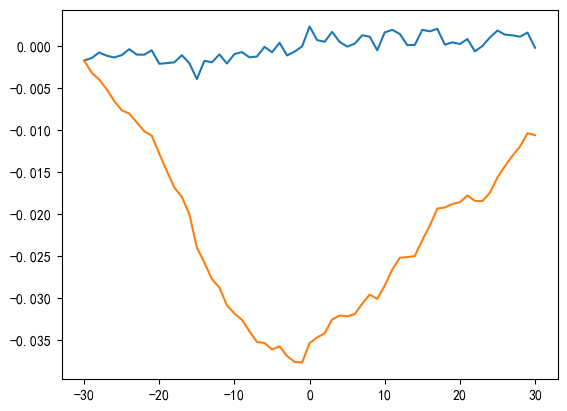

In [194]:
res = {}
res[0] = data[data.is_xx==1]['ro1'].mean()
for i in np.arange(1,31):
    res[i] = data[data.is_xx.shift(i)==1]['ro1'].mean()
for i in np.arange(1,31):
    res[-1*i] = data[data.is_xx.shift(-1*i)==1]['ro1'].mean()
pd.Series(res).sort_index().plot()
pd.Series(res).sort_index().cumsum().plot()

<Axes: >

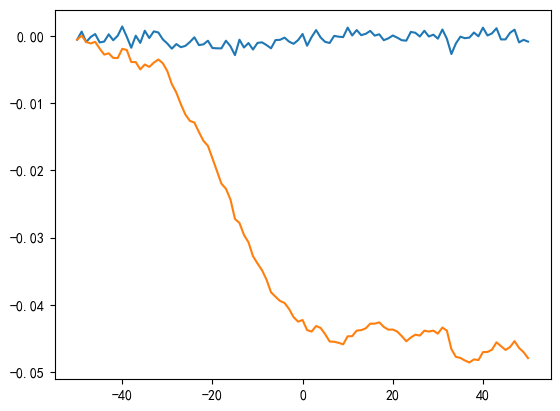

In [192]:
res = {}
res[0] = data[data.is_xx==1]['alpha_ro1'].mean()
for i in np.arange(1,51):
    res[i] = data[data.is_xx.shift(i)==1]['alpha_ro1'].mean()
for i in np.arange(1,51):
    res[-1*i] = data[data.is_xx.shift(-1*i)==1]['alpha_ro1'].mean()
pd.Series(res).sort_index().plot()
pd.Series(res).sort_index().cumsum().plot()